# Hàm tách nền 

In [5]:
import cv2
import numpy as np
import os
import glob
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def resize_before_processing(image, scale=0.75):
    """ Giảm kích thước ảnh để tăng tốc xử lý """
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w * scale), int(h * scale)))

def remove_background(image):
    """ Dùng GrabCut để tách nền """
    mask = np.zeros(image.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    rect = (10, 10, image.shape[1] - 20, image.shape[0] - 20)
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    return image * mask_2[:, :, np.newaxis]

def crop_to_object(image):
    """ Cắt phần thừa xung quanh chủ thể """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image  # Trả về ảnh gốc nếu không tìm thấy contour

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    return image[y:y+h, x:x+w]

def process_image(image_path, output_path):
    # Bỏ qua nếu ảnh đã xử lý
    if os.path.exists(output_path):
        return

    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Lỗi đọc ảnh: {image_path}")
        return

    # Resize trước khi xử lý để tăng tốc nếu ảnh quá lớn
    image = resize_before_processing(image, scale=1)

    object_only = remove_background(image)
    cropped_object = crop_to_object(object_only)

    cv2.imwrite(output_path, cropped_object)

def process_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    subfolders = [f.path for f in os.scandir(input_folder) if f.is_dir()]

    for subfolder in subfolders:
        category_name = os.path.basename(subfolder)
        output_subfolder = os.path.join(output_folder, category_name)

        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        image_paths = glob.glob(os.path.join(subfolder, "*.jpg"))
        output_paths = [os.path.join(output_subfolder, os.path.basename(p)) for p in image_paths]

        with ThreadPoolExecutor() as executor:
            list(tqdm(executor.map(process_image, image_paths, output_paths),
                      total=len(image_paths), desc=f"Processing {category_name}"))

# Gọi hàm xử lý
input_folder = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Notebook\path_to_merged"  # Thay đường dẫn
output_folder = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\15class_grabcut_nobg"
process_images(input_folder, output_folder)


Processing Wood Ear: 100%|██████████| 317/317 [01:09<00:00,  4.54it/s]


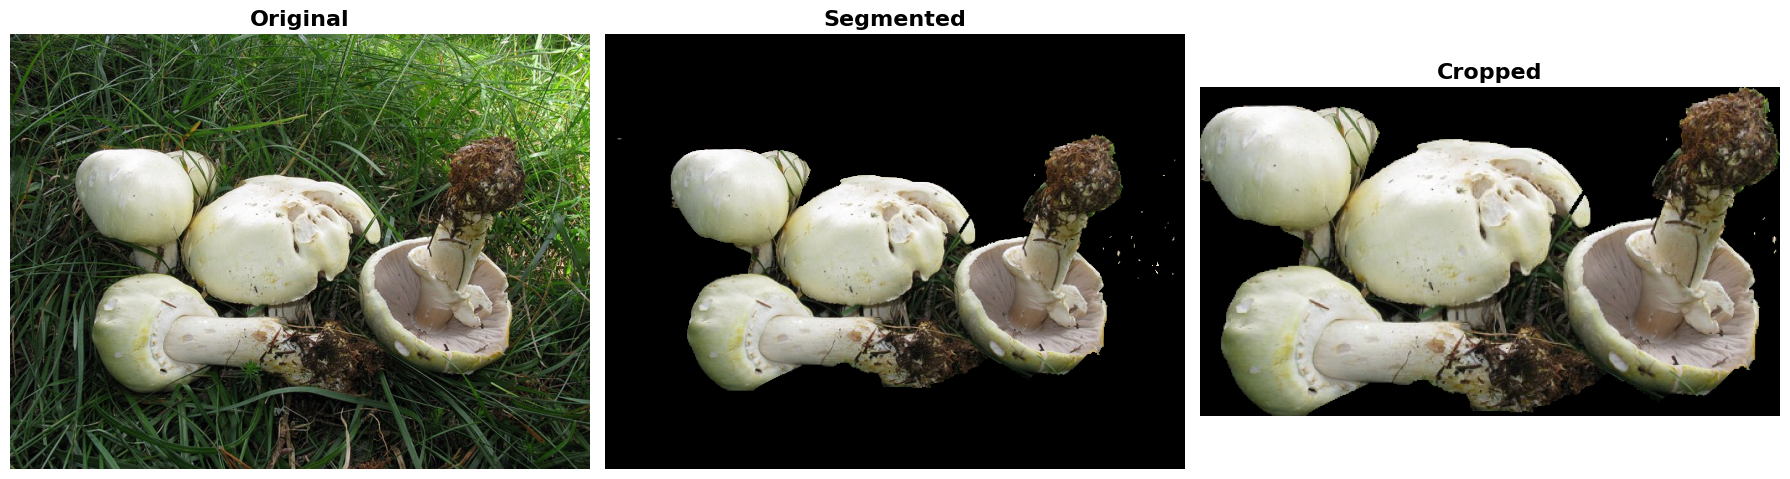

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_before_processing(image, scale=0.75):
    """ Giảm kích thước ảnh để tăng tốc xử lý """
    h, w = image.shape[:2]
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
    
  

    return resized_image


def remove_background(image):
    """ Dùng GrabCut để tách nền """
    mask = np.zeros(image.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    rect = (10, 10, image.shape[1] - 20, image.shape[0] - 20)
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 10, cv2.GC_INIT_WITH_RECT)

    mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    segmented_image = image * mask_2[:, :, np.newaxis]
    
    return segmented_image

def crop_to_object(image):
    """ Cắt phần thừa xung quanh chủ thể """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros_like(image)  # Trả về ảnh nền đen nếu không tìm thấy vật thể

    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return image[y:y+h, x:x+w]

def display_images(images, titles):
    plt.figure(figsize=(18, 5))  # Mở rộng khung hình
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title, fontsize=16, fontweight='bold')
        
        
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Đọc ảnh
image_path = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Mushrooms\Agaricus\003_4AurAO4Jil8.jpg"
original_image = cv2.imread(image_path)

# Kiểm tra nếu ảnh không đọc được
if original_image is None:
    raise ValueError("Không thể đọc ảnh, kiểm tra lại đường dẫn.")


# Thực hiện các bước xử lý ảnh
resized = resize_before_processing(original_image)
segmented = remove_background(resized)
cropped = crop_to_object(segmented)

# Hiển thị ảnh
images = [original_image,  segmented, cropped]
titles = ["Original", "Segmented", "Cropped"]
display_images(images, titles)


In [7]:
import os

# Thư mục chứa dataset
dataset_path = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Notebook\path_to_merged"

# Duyệt qua từng thư mục con
split_info = {}

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Chỉ xét thư mục con
        total_images = len(os.listdir(folder_path))  # Số ảnh trong thư mục con
        num_train = int(0.8 * total_images)
        num_test = total_images - num_train
        split_info[folder] = {"Train": num_train, "Test": num_test}

# In kết quả
for folder, split in split_info.items():
    print(f"{folder}: Train = {split['Train']}, Test = {split['Test']}")


Chanterelle: Train = 76, Test = 19
Dried Shiitake: Train = 296, Test = 75
Dried Wood Ear: Train = 336, Test = 85
Enoki: Train = 293, Test = 74
King Oyster: Train = 223, Test = 56
Lingzhi: Train = 168, Test = 42
Oyster: Train = 300, Test = 75
Red Pine: Train = 184, Test = 47
Shiitake: Train = 359, Test = 90
Shimeji: Train = 288, Test = 73
Snow: Train = 219, Test = 55
Straw: Train = 355, Test = 89
Truffle: Train = 129, Test = 33
White Button: Train = 326, Test = 82
Wood Ear: Train = 253, Test = 64


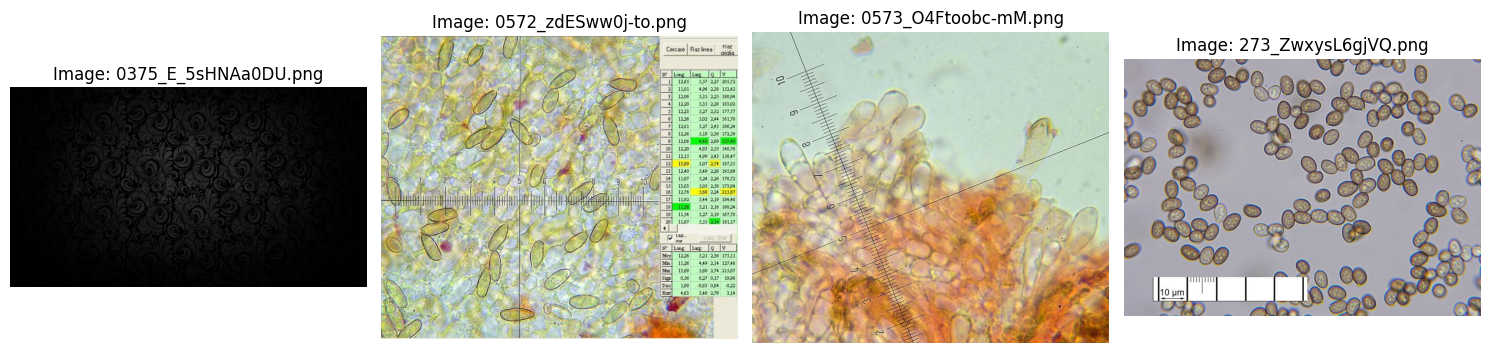

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Đường dẫn tới thư mục chứa ảnh lỗi
folder_path = r'C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\Error_to_show'

# Lấy danh sách tất cả các tệp ảnh trong thư mục
image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'png', 'jpeg'))]

# Tạo hình ảnh để hiển thị ảnh lỗi
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))

# Nếu chỉ có một ảnh, axes sẽ là một đối tượng đơn lẻ, ta cần xử lý trường hợp này
if len(image_files) == 1:
    axes = [axes]

# Hiển thị từng ảnh
for ax, img_file in zip(axes, image_files):
    img_path = os.path.join(folder_path, img_file)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Tắt trục để ảnh rõ hơn
    ax.set_title(f"Image: {img_file}")  # Hiển thị tên ảnh

# Hiển thị các ảnh
plt.tight_layout()
plt.show()


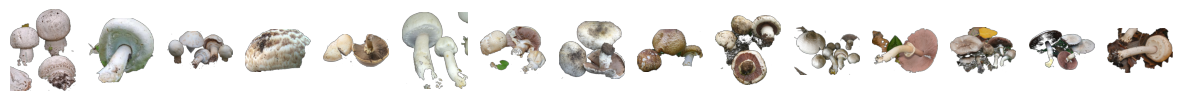

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import glob

def remove_black_background(image):
    """ Biến nền đen thành trong suốt """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # Lọc nền đen

    # Tạo ảnh có kênh alpha
    b, g, r = cv2.split(image)
    alpha = mask
    transparent_img = cv2.merge([r, g, b, alpha])  # OpenCV dùng BGR, đổi thành RGB

    return transparent_img

def show_random_images(input_folder, num_images=5):
    """ Chọn ngẫu nhiên num_images ảnh từ folder, xử lý và hiển thị """
    image_paths = glob.glob(f"{input_folder}/*.jpg")
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
    if len(selected_images) == 1:
        axes = [axes]  # Đảm bảo axes là list nếu chỉ có 1 ảnh

    for ax, img_path in zip(axes, selected_images):
        image = cv2.imread(img_path)
        if image is None:
            continue

        transparent_img = remove_black_background(image)

        ax.imshow(transparent_img)
        ax.axis("off")

    plt.show()

# Chạy thử với folder ảnh của bạn
show_random_images(r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\5_grabcut_nobg\Agaricus", num_images=15)


In [3]:
import cv2
import numpy as np
import os
import glob

def remove_black_background(image):
    """ Biến nền đen thành trong suốt """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # Lọc nền đen

    # Tạo ảnh có kênh alpha
    b, g, r = cv2.split(image)
    alpha = mask
    transparent_img = cv2.merge([b, g, r, alpha])  # OpenCV dùng BGR

    return transparent_img

def process_folder(input_folder, output_folder):
    """ Xử lý toàn bộ ảnh trong folder con của input_folder """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for class_name in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_name)
        output_class_path = os.path.join(output_folder, class_name)

        if not os.path.isdir(class_path):
            continue  # Bỏ qua nếu không phải folder

        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)  # Tạo folder con

        image_paths = glob.glob(os.path.join(class_path, "*.jpg")) + glob.glob(os.path.join(class_path, "*.jpeg")) + glob.glob(os.path.join(class_path, "*.png"))
        for img_path in image_paths:
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Đọc ảnh 3 kênh
            if image is None:
                continue

            transparent_img = remove_black_background(image)

            # Chuyển định dạng PNG
            save_path = os.path.join(output_class_path, os.path.splitext(os.path.basename(img_path))[0] + ".png")
            cv2.imwrite(save_path, transparent_img, [cv2.IMWRITE_PNG_COMPRESSION, 9])

    print("✅ Hoàn tất tách nền!")



# Chạy thử
input_folder = r"C:\Users\DO TUAN MINH\Desktop\ben\Learn\AIL303m\5_grabcut_nobg"
output_folder = "5_grab_cut_PNG"
process_folder(input_folder, output_folder)


✅ Hoàn tất tách nền!
